In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import keras
import cv2 as cv

## Loading Data

In [2]:
dataDir = "C:\D\College Stuff\Semester 4\Summer Internship\Parking-Spot-Detection\Resources\Data"
data = tf.keras.utils.image_dataset_from_directory(dataDir, batch_size=400, image_size=(49,109))

Found 7200 files belonging to 2 classes.


In [3]:
dataIterator = data.as_numpy_iterator()

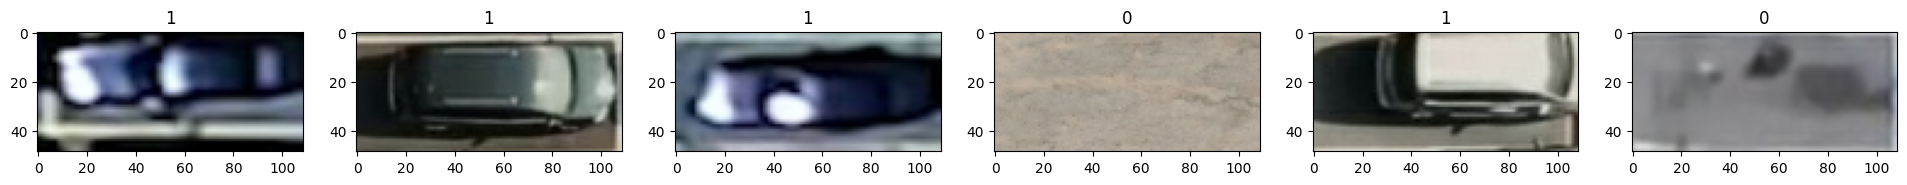

In [4]:
batch = dataIterator.next()
fig, ax = plt.subplots(ncols=6, figsize=(24,54))
for idx, img in enumerate(batch[0][:6]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## Scale Data

In [5]:
data = data.map(lambda x,y: (x/255, y))

In [ ]:
# data.as_numpy_iterator().next()

## Split Data

In [6]:
trainSize = int(len(data)*.7)
valSize = int(len(data)*.2)
testSize = int(len(data)*.1)

trainSize+valSize+testSize

16

In [7]:
trainDataSet = data.take(trainSize)
valDataSet = data.skip(trainSize).take(valSize)
testDataSet = data.skip(trainSize+valSize).take(testSize)

## Building Model

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [9]:
model = Sequential()

model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(49, 109, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [10]:
from keras.callbacks import EarlyStopping
from keras import backend as K


early_stopping = EarlyStopping(
    monitor='accuracy', patience=3, verbose=1, mode='max', restore_best_weights=True)


def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [11]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy', 'loss', recall_m, precision_m, f1_m])

In [12]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 47, 107, 16)       448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 53, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 51, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 25, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 23, 16)         4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 11, 16)        0

## Training the Data

In [ ]:
from keras.callbacks import EarlyStopping
from keras import backend as K


early_stopping = EarlyStopping(
    monitor='accuracy', patience=3, verbose=1, mode='max', restore_best_weights=True)


def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [13]:
logdir='logsTest5'
tensorboardCallback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [14]:
hist = model.fit(trainDataSet, epochs=20, validation_data=valDataSet,
                 callbacks=[early_stopping, tensorboardCallback])


Epoch 1/20
12/12 [==============================] - 17s 1s/step - loss: 0.5595 - accuracy: 0.6648 - recall_m: 0.9154 - precision_m: 0.6095 - f1_m: 0.7157 - val_loss: 0.3045 - val_accuracy: 0.9858 - val_recall_m: 0.9933 - val_precision_m: 0.9783 - val_f1_m: 0.9857
Epoch 2/20
12/12 [==============================] - 16s 1s/step - loss: 0.1414 - accuracy: 0.9773 - recall_m: 0.9653 - precision_m: 0.9890 - f1_m: 0.9768 - val_loss: 0.0552 - val_accuracy: 0.9883 - val_recall_m: 0.9984 - val_precision_m: 0.9799 - val_f1_m: 0.9891
Epoch 3/20
12/12 [==============================] - 21s 2s/step - loss: 0.0359 - accuracy: 0.9898 - recall_m: 0.9867 - precision_m: 0.9925 - f1_m: 0.9895 - val_loss: 0.0133 - val_accuracy: 0.9983 - val_recall_m: 1.0000 - val_precision_m: 0.9968 - val_f1_m: 0.9984
Epoch 4/20
12/12 [==============================] - 17s 1s/step - loss: 0.0123 - accuracy: 0.9979 - recall_m: 0.9983 - precision_m: 0.9974 - f1_m: 0.9979 - val_loss: 0.0127 - val_accuracy: 0.9958 - val_recall

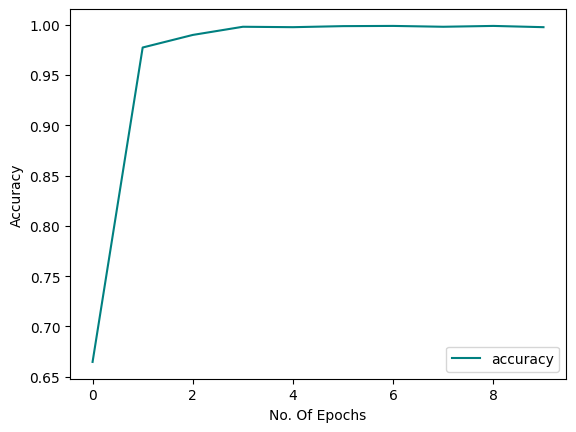

In [15]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.legend(["accuracy"], loc="lower right")
plt.xlabel("No. Of Epochs")
plt.ylabel("Accuracy")
plt.show()


(0.0, 10.0)

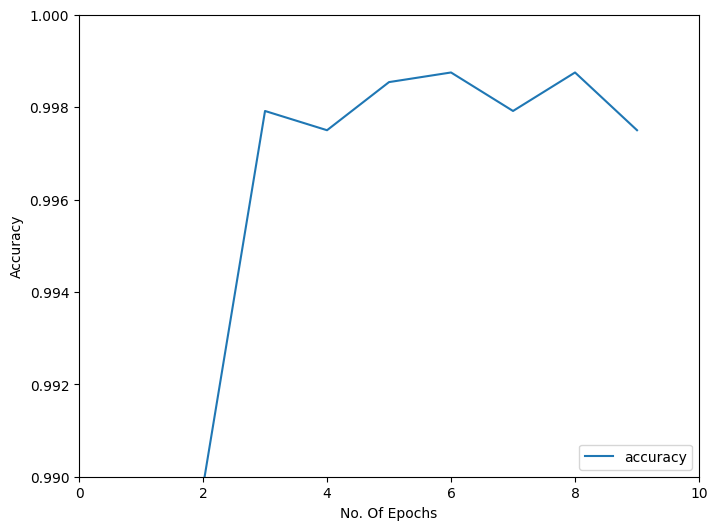

In [21]:
import seaborn as sns
data = np.array(hist.history["accuracy"]).reshape(-1, 1)

plt.figure(figsize=(8, 6))
ax = sns.lineplot(data)
plt.legend(["accuracy"], loc="lower right")
plt.xlabel("No. Of Epochs")
plt.ylabel("Accuracy")
ax.set_ylim(0.99, 1)
ax.set_xlim(0, 10)

# ax.set(yscale="log")


Text(70.72222222222221, 0.5, 'No. Of Epochs')

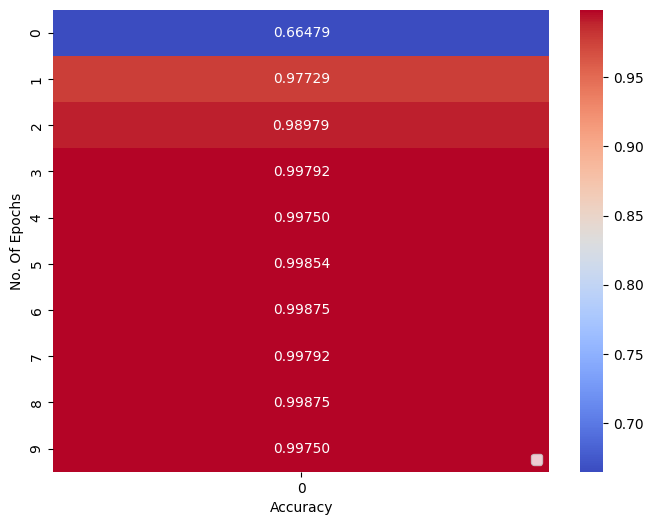

In [22]:
import seaborn as sns
data = np.array(hist.history["accuracy"]).reshape(-1, 1)

plt.figure(figsize=(8, 6))
sns.heatmap(data, annot=True, cmap="coolwarm", fmt=".5f")
plt.legend(["accuracy"], loc="lower right")
plt.xlabel("Accuracy")
plt.ylabel("No. Of Epochs")


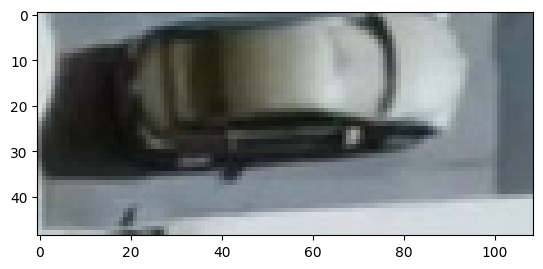

In [23]:
img = cv.imread("1189.jpg")
plt.imshow(img)
plt.show()

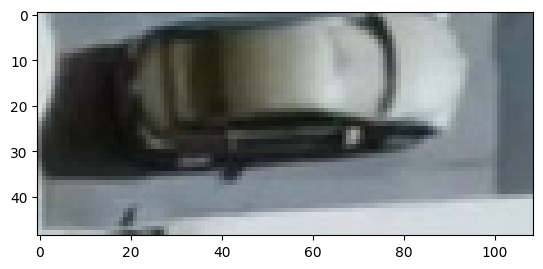

In [24]:
resize = tf.image.resize(img, (49,109))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [25]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 96ms/step


In [26]:
yhat

array([[0.9999984]], dtype=float32)

In [27]:
if yhat > 0.5: 
    print(f'Predicted class is Occupied spot.')
else:
    print(f'Predicted class is Empty spot.')

Predicted class is Occupied spot.


## Saving the model

In [28]:
from tensorflow.keras.models import load_model
model.save(os.path.join('models','parkingSpotClassifierV6.hdf5'))

In [ ]:
from keras.callbacks import EarlyStopping
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


logdir = 'logsTest'
from tensorflow.keras.models import load_model

newModel = load_model("models/parkingSpotClassifierV3.h5", compile=False)

early_stopping = EarlyStopping(
    monitor='accuracy', patience=3, verbose=1, mode='max', restore_best_weights=True)

newModel.compile(loss="binary_crossentropy", metrics = ["accuracy", recall_m, precision_m, f1_m])

In [ ]:
newModel.evaluate(testDataSet)

In [ ]:
answer =  newModel.predict(np.expand_dims(resize/255, 0))
# print(answer[0][0])

In [ ]:
answer